#  Recommender Assignment 


## Table of Content
1. Environment Set Up & Data Pre-Processing
2. Exploratory Data Analysis
3. Recommender System

# 1. Environment Set Up & Data Pre-Processing

In [1]:
# importing all necessary modules

# Data manipulation
import pandas as pd
import numpy as np

#Data Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

#NLP data packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

# do not print warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read all files 
article = pd.read_csv(r"articles.csv", encoding ="utf-8")
user = pd.read_csv("users.csv")
reading = pd.read_csv("reading.csv")

In [54]:
# observe the shape of the datasets
print(article.shape, user.shape, reading.shape)

(84066, 5) (179523, 4) (5956753, 3)


In [4]:
# inspect article dataset
article.head()

,article_id,published_time,title,domain,category
0,280665035534066165,2022-04-13 15:22:08,"Đổ xăng xong nhưng bùng tiền, tài xế méo mặt k...",giadinh.net.vn,Đời sống
1,553165162239741497,2022-04-08 04:40:00,"Sài Gòn: Chán màu xanh dương, Mercedes-AMG G63...",xehay.vn,Xe
2,4936028575939004693,2022-04-08 08:25:00,"Khai mạc Kỳ họp thứ Tư, HĐND thành phố Hà Nội ...",kinhtedothi.vn,Xã hội
3,5371965639343924869,2022-04-12 15:07:43,Lão nông đào được viên đá lạ đem bán 2000 đồng...,giadinh.net.vn,Khoa học
4,6042543455069651737,2022-04-11 07:14:34,Cưu mang chú chó 3 chân không ngờ chú chó cứu ...,giadinh.net.vn,Đời sống


In [5]:
# inspect user dataset
user.head()

,user_id,gender,age,os_name
0,4716260340891938377,Female,<18,windows
1,15290165232401343976,Male,<18,windows
2,13521408200001072707,Female,<18,windows
3,12660877307552158199,Female,<18,windows
4,13273334199460270956,Female,<18,windows


In [6]:
# inspect reading dataset
reading.head()

,user_id,article_id,event_time
0,13214459406561935989,14810025847983156880,2022-04-06 00:00:00
1,1289026229861087090,17510905596044558175,2022-04-06 00:00:00
2,3001758567334363234,9741355532714246116,2022-04-06 00:00:00
3,9935763984618015567,7546671372785216919,2022-04-06 00:00:00
4,10238108363219256632,13307914094188214671,2022-04-06 00:00:01


Checking for missing values in all datasets:

In [7]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179523 entries, 0 to 179522
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  179523 non-null  uint64
 1   gender   179523 non-null  object
 2   age      179523 non-null  object
 3   os_name  179523 non-null  object
dtypes: object(3), uint64(1)
memory usage: 5.5+ MB


In [8]:
reading.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956753 entries, 0 to 5956752
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     5956753 non-null  uint64
 1   article_id  5956753 non-null  uint64
 2   event_time  5956753 non-null  object
dtypes: object(1), uint64(2)
memory usage: 136.3+ MB


In [9]:
article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84066 entries, 0 to 84065
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   article_id      84066 non-null  uint64
 1   published_time  84066 non-null  object
 2   title           84066 non-null  object
 3   domain          84066 non-null  object
 4   category        84066 non-null  object
dtypes: object(4), uint64(1)
memory usage: 3.2+ MB


There are no missing values in all dataset provided. 

### Extract Date & Time

In [55]:
# Merge 3 datasets together
# I will left join the dataset reading with the other two because I want to keep the number of reads intact
df2 = reading.merge(article,on='article_id', how='left'
    ).merge(user, on='user_id', how='left')

In [56]:
# Convert published time to datetime data type
df2["published_time"] = pd.to_datetime(df2['published_time'])
df2["event_time"] = pd.to_datetime(df2['event_time'])
# Extract Date
df2['publish_date'] = df2['published_time'].dt.date
df2['publish_date'] = df2['publish_date'].astype(str)

# 2. Exploratory Data Analysis

The data is gauged in the first half of April 2022, from 1/4/2022 to 12/4/2022. Thus,  days of the week, monthly or yearly trends will not be considered in this analysis. 
In total, there are 84,066 unique articles published, 179,523 unique users and 5,956,753 reads on Website A during this period. 

Text(0.5, 1.0, 'Users Age Distribution')

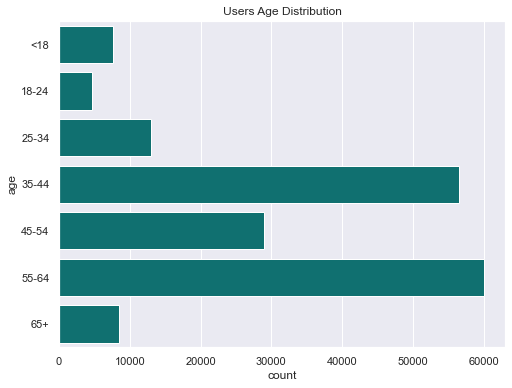

In [12]:
#visualize user's age distribution

# increase the size of the following seaborn countplot
sns.set(rc={'figure.figsize':(8,6)})

# use the seaborn countplot function 
ax = sns.countplot(y='age',data=user,color='teal',
            order=['<18','18-24','25-34','35-44','45-54','55-64','65+'])

# set the title of the plot
ax.set_title('Users Age Distribution')

The bulk of Website A's users are between the ages of 35 and 64, as shown above. Website A's users are a bit old, thus the team can leverage on the data collected to keep them interested. At the same time, because millenials and Generation Z are heavy internet users, Website A might conduct some research(survey or from collected data) to see how to improve the UX design and content to appeal to this demographic.

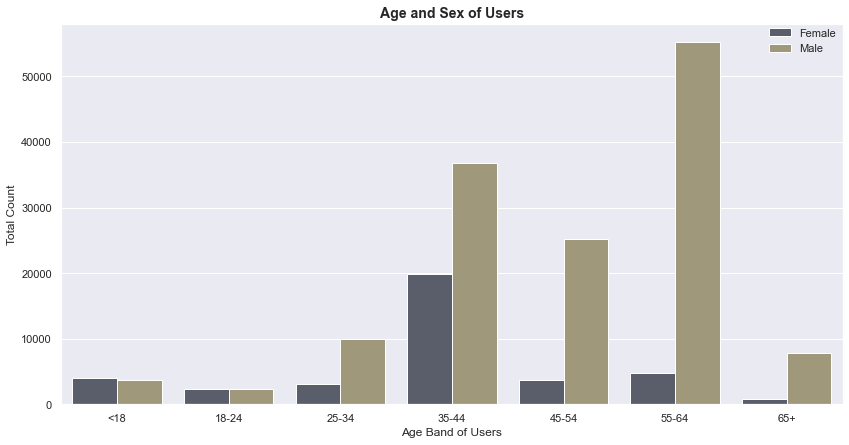

In [13]:
# creating a new dataframe and renaming the columns based out of grouping
age_gender = user.groupby(['age', 'gender']).size().reset_index()
age_gender.columns = ['age', 'gender','total']

# seaborn barplot distribution
sns.set_style('darkgrid')
fig, axis = plt.subplots(figsize=(14, 7))
sns.barplot(y='total', x='age', hue='gender', data=age_gender, palette='cividis', 
           order=['<18','18-24','25-34','35-44','45-54','55-64','65+'])

axis.set_title('Age and Sex of Users', fontsize=14, fontweight='bold')
axis.set(xlabel='Age Band of Users', ylabel='Total Count')
axis.legend(bbox_to_anchor=(0.9, 1.), borderaxespad=0., frameon=False)

We can see an extremely disproportionate number of female and male consumers (the number of male is more than thrice that of female). Most female users are around 35-44. We can consider strategies to improve the design and products in order to appeal to more female users.

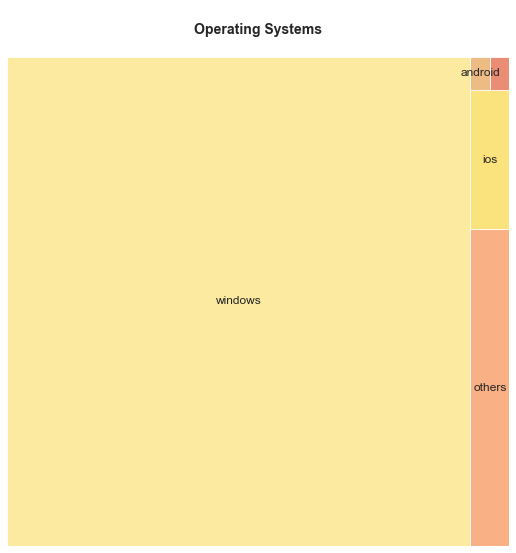

In [14]:
# Operating Systems
#prepare the data
os = user.groupby('os_name').size()\
                                                .reset_index(name='counts')\
                                                    .sort_values(by='counts', ascending=False)
#draw a treemap
fig, ax = plt.subplots(1, figsize = (9,9))
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
squarify.plot(sizes=os['counts'], 
              label=os['os_name'][:4], color = colors,
              alpha=.8 )
plt.title('\nOperating Systems\n', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

The majority of Website A's users are Windows users.

Text(0.5, 1.0, '10 Most Popular Categories')

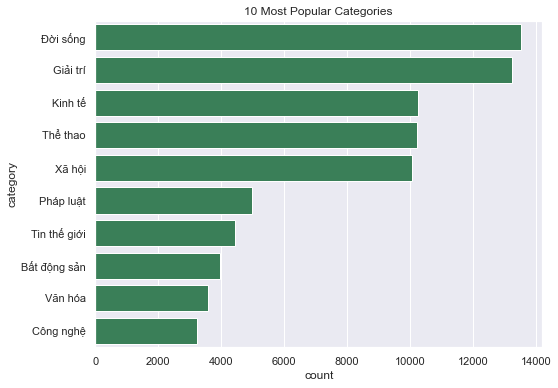

In [15]:
#visualize 10 most popular categories

# increase the size of the following seaborn countplot
sns.set(rc={'figure.figsize':(8,6)})

# use the seaborn countplot function 
ax = sns.countplot(y='category',data=article,color='seagreen',
            order=article.category.value_counts().iloc[:10].index)

# set the title of the plot
ax.set_title('10 Most Popular Categories')

Text(0.5, 1.0, '10 Most Visited Domains')

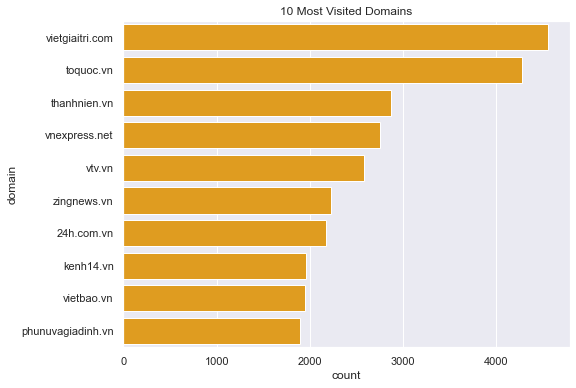

In [16]:
#visualize 10 most visited domains

# increase the size of the following seaborn countplot
sns.set(rc={'figure.figsize':(8,6)})

# use the seaborn countplot function 
ax = sns.countplot(y='domain',data=article,color='orange',
            order=article.domain.value_counts().iloc[:10].index)

# set the title of the plot
ax.set_title('10 Most Visited Domains')

[Text(0, 0.5, 'Total Counts')]

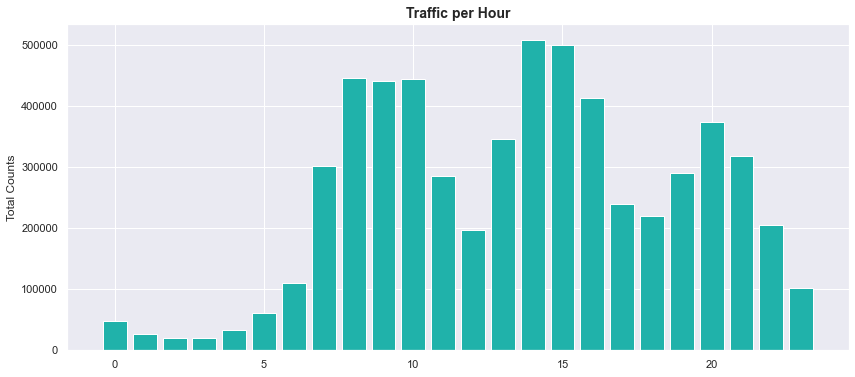

In [17]:
# Preparing the plot for the total traffic per hour at Website A
total_count = df2['event_time'].dt.hour.value_counts().sort_index(ascending=False)
sns.set_style('darkgrid')
fig, axis = plt.subplots(figsize=(14,6))

# plot
axis.bar(total_count.index, total_count.values, color='lightseagreen')
axis.set_title('Traffic per Hour', fontsize=14, fontweight='bold')
axis.set(ylabel='Total Counts')

Users are most active on Website A during three peak periods: 7-10, 14-16, and 19-21.

The datasets provided contain a lot of text, allowing us to experiment with text mining. I'd like to create two word clouds here, one of which is a word cloud containing content from the last two weeks' worth of news. Another will be a word cloud of the content that readers have read in the last two weeks. We will proceed to compare the differences.

In [57]:
# load stop words
def get_stopwords_list(stop_file_path):
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))

In [58]:
#download and use stopwords list
stopwords_path = "/Users/thuynguyenphan/Downloads/vietnamese-stopwords-master/vietnamese-stopwords.txt"
stop_w = get_stopwords_list(stopwords_path) 

In [67]:
# combine all titles into a big text 
text = " ".join(title for title in article.title)

In [68]:
# create a word cloud from the big text
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_w,
                min_font_size = 10).generate(text)

Here we see what the news are covering the most in the first half of April 2022. 

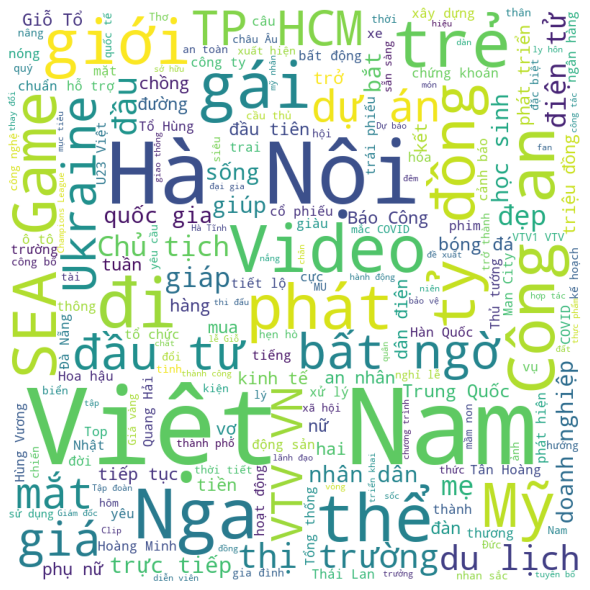

In [22]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [8]:
# combine all titles into a big text 
text2 = " ".join(title for title in df2.title)

In [9]:
# create a word cloud from the big text
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_w,
                min_font_size = 10).generate(text2)

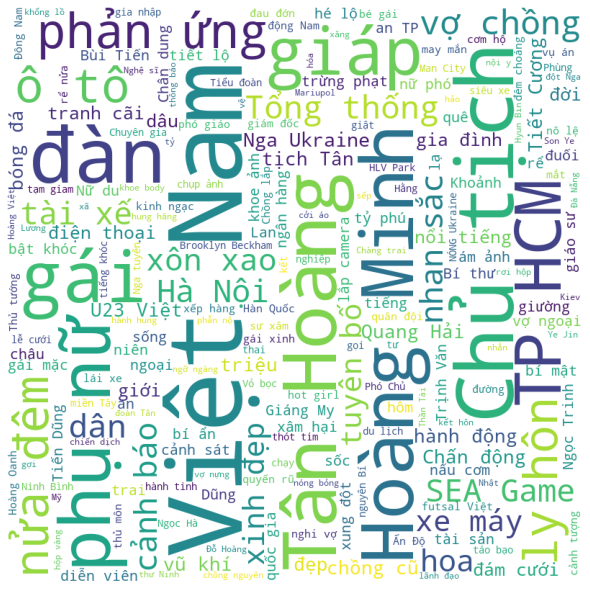

In [10]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Here we see the most read topics from the users:

The two word clouds provide some intriguing information about Website A users. As we can see, the media covers a variety of 'hot issues,' such as the Ukraine-Russia conflict, SEA GAMES, and so on, but Website A's users have a different set of interests. The second word cloud, for example, indicated a high level of interest in stories about Tan Hoang Minh in the previous two weeks.

# 3. Recommender System

## Female user

In [59]:
female_user = df2.loc[(df2['user_id'] == 10905364777234019509)]
female_user

,user_id,article_id,event_time,published_time,title,domain,category,gender,age,os_name,publish_date
310925,10905364777234019509,12109782618279411015,2022-04-06 10:26:10,2022-04-05 16:38:26,"Trâm Anh, Hiền Hồ cùng nói về chuyện yêu đại g...",24h.com.vn,Giải trí,Female,35-44,windows,2022-04-05
313070,10905364777234019509,11208040010033435446,2022-04-06 10:27:40,2022-04-06 06:30:00,"Yên ắng hậu ly hôn, Ngọc Quyên bất ngờ đăng ản...",eva.vn,Giải trí,Female,35-44,windows,2022-04-06
320079,10905364777234019509,6326202818240594057,2022-04-06 10:32:33,2022-04-06 08:31:00,Anh Sa - con gái duy nhất của Hoa hậu Đền Hùng...,ngoisao.vn,Giải trí,Female,35-44,windows,2022-04-06
771551,10905364777234019509,8291848492435494400,2022-04-06 16:53:06,2022-04-05 22:04:54,Ba người con của Chủ tịch Tân Hoàng Minh,zingnews.vn,Giải trí,Female,35-44,windows,2022-04-05
1156658,10905364777234019509,540352328595613069,2022-04-07 07:51:18,2022-04-06 08:41:00,Hoa hậu Giáng My: Cuộc sống tuổi 51 giàu sang ...,kenh14.vn,Giải trí,Female,35-44,windows,2022-04-06
1157127,10905364777234019509,540352328595613069,2022-04-07 07:51:41,2022-04-06 08:41:00,Hoa hậu Giáng My: Cuộc sống tuổi 51 giàu sang ...,kenh14.vn,Giải trí,Female,35-44,windows,2022-04-06
1158908,10905364777234019509,10567420843860852779,2022-04-07 07:53:04,2022-04-06 07:30:00,"Đang đi vệ sinh thì có cảm giác bị quay lén, n...",kenh14.vn,Giáo dục,Female,35-44,windows,2022-04-06
1164852,10905364777234019509,5194865632474069862,2022-04-07 07:57:42,2022-04-06 10:55:00,Ngắm đã đời loạt ảnh Lọ Lem nhà MC Quyền Linh ...,kenh14.vn,Giải trí,Female,35-44,windows,2022-04-06
1165609,10905364777234019509,1040006270542563473,2022-04-07 07:58:18,2022-04-07 00:42:26,"Nam Em, Hoàng Thùy Linh lộ nhan sắc thật qua l...",24h.com.vn,Giải trí,Female,35-44,windows,2022-04-07
1168122,10905364777234019509,568810083492393024,2022-04-07 08:00:12,2022-04-06 13:32:30,Anh Sa - cô con gái xinh đẹp và kín tiếng của ...,danviet.vn,Giải trí,Female,35-44,windows,2022-04-06


In [60]:
#The female user_id reads the majority of articles in the category 'Giải trí'
female_category = female_user.groupby('category').size()\
                                                .reset_index(name='total reading')\
                                                    .sort_values(by='total reading',ascending=False)
female_category

,category,total reading
1,Giải trí,34
5,Đời sống,6
0,Giáo dục,5
2,Pháp luật,3
3,Tin thế giới,1
4,Văn hóa,1


User_id 10905364777234019509 is a female, of age group 35-44 and mainly read article in category 'Giải trí'. In this exercise, I will use the articles that have been read by other female of the same age group, of the category 'Giải trí' only to recommend to this user.  Also, I will only recommend this user with the most up-to-date article to read, which means that all articles recommended will be published in 12/4: 

In [61]:
female_group = df2.loc[(df2['gender'] == 'Female')& (df2['age'] == '35-44') & (df2['category'] == 'Giải trí')  
                       & (df2['publish_date'] =='2022-04-12')]
female_group.head()

,user_id,article_id,event_time,published_time,title,domain,category,gender,age,os_name,publish_date
4963659,13103497774193990007,2689619685294258781,2022-04-12 05:41:10,2022-04-12 00:16:00,Á hậu Hoàng Oanh ly hôn chồng Tây,eva.vn,Giải trí,Female,35-44,windows,2022-04-12
4964167,6231682246098625032,2689619685294258781,2022-04-12 05:44:23,2022-04-12 00:16:00,Á hậu Hoàng Oanh ly hôn chồng Tây,eva.vn,Giải trí,Female,35-44,windows,2022-04-12
4970380,1141828799405394311,4524101835322441594,2022-04-12 06:16:14,2022-04-12 00:04:00,"Hot girl phòng Gym Huyền Trân vòng ba 103 cm, ...",24h.com.vn,Giải trí,Female,35-44,windows,2022-04-12
4973281,9562876085397266271,6514309544745596910,2022-04-12 06:29:05,2022-04-12 00:06:00,Trâm Anh rửa xe 2 tỷ được nhân vật quyền lực t...,24h.com.vn,Giải trí,Female,35-44,windows,2022-04-12
4974441,1221359499195294216,6514309544745596910,2022-04-12 06:33:59,2022-04-12 00:06:00,Trâm Anh rửa xe 2 tỷ được nhân vật quyền lực t...,24h.com.vn,Giải trí,Female,35-44,windows,2022-04-12


In [62]:
# remove duplicates from the list of articles that the female users have read
female_user.drop_duplicates(subset='title',keep='first',inplace=True)
X= female_user['title'].values.tolist()


In [64]:
# remove duplicates and take only the title from the dataframe
Y= female_group['title'].values.tolist()
Z =[]
for n in Y:
        if n not in Z:
            Z.append(n)

In [65]:
#create a pool of data with the suggested articles and the original pool of articles that the user has read
combine = X+Z

#Remove duplicates
combine = list(dict.fromkeys(combine))
combine = pd.DataFrame (combine, columns = ['title'])

In [66]:
#Define a TF-IDF Vectorizer Object. Remove all vietnamese stop words
vectorizer = TfidfVectorizer(
                     stop_words=stop_w)

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = vectorizer.fit_transform(combine['title'])

tfidf_feature_name = vectorizer.get_feature_names_out()


#Output the shape of tfidf_matrix
tfidf_matrix.shape

(630, 1718)

In [67]:
# comping cosine similarity matrix using linear_kernal of sklearn
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [68]:
#Construct a reverse map of indices and titles
indices = pd.Series(combine['title'])

inddict = indices.to_dict()

#changing the selection of articles from index to title
inddict = dict((v,k) for k,v in inddict.items())

In [69]:
# Function that takes in title as input and outputs most similar articles
def get_recommendations(title):
    # Get the index of the articles that matches the title
    id = inddict[title]

    # Get the pairwise similarity scores of all articles with that articles
    sim_scores = list(enumerate(cosine_similarity[id]))

    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 2 most similar articles
    sim_scores = sim_scores[1:3]

    # Get the articles indices
    article_indices = [i[0] for i in sim_scores]

    # Return the top 2 most similar articles
    return combine['title'].loc[article_indices]

In [47]:
#test
get_recommendations('Trâm Anh, Hiền Hồ cùng nói về chuyện yêu đại gia nhưng khác nhau thế này')

185       Thiều Bảo Trâm: Tình yêu bây giờ dễ đến, dễ đi
82     Phát ngôn gây sốc về tình yêu Trâm Anh làm net...
Name: title, dtype: object

In [70]:
#Create a list of all the recommended articles for the female users 
recomm_list = []
recomm =[]
for i in X:
    recomm_i = get_recommendations(i)
    recomm_list.append(recomm_i.values[0])
    recomm_list.append(recomm_i.values[1])
    for n in recomm_list:
        if n not in recomm:
            recomm.append(n)
  

In [71]:
#Convert the list to a dataframe
female_recomm= pd.DataFrame (recomm, columns = ['title'])

# popularity recommender


Here we look at the list of the most popular articles for female, age group 35-44 based of the number of reads for each articles. 

In [72]:
# Popularity recommender
female_popularity = female_group.groupby('title').size()\
                                                .reset_index(name='total reading')\
                                                    .sort_values(by='total reading',ascending=False)
female_popularity

,title,total reading
242,Jack Cole thông báo ly hôn MC Hoàng Oanh,1129
290,MC Hoàng Oanh nói 1 câu cực gắt vào vài phút t...,844
197,Hoàng Oanh nói gì 15 phút trước khi chồng tuyê...,513
474,Trai đẹp si tình ở Gia Đình Là Số 1 giờ đã thà...,494
223,Hình ảnh vợ chồng David Beckham trong lễ cưới ...,481
...,...,...
459,Thương ngày nắng về 2 - Tập 5: Trang ghen ra m...,1
460,Thương ngày nắng về 2 - Tập 5: Đức say rượu đẩ...,1
462,Thương ngày nắng về: Hai lần cưỡng hôn rồi chả...,1
151,Dàn sao Việt hài hước bắt trend tóc “sư tử” củ...,1


In [73]:
# top 10 recommended article for female users
female_list = female_recomm.merge(female_popularity,on='title', how='left'
    )
female_list.sort_values(by=['total reading'],ascending=False).head(10)


,title,total reading
49,Người đẹp múa gậy khiến Tôn Ngộ Không ngơ ngác,306.0
3,Chồng Hoàng Oanh bất ngờ xác nhận ly hôn: 'Tin...,263.0
42,"Vợ Khắc Việt, Tuấn Hưng sinh con càng đẹp hơn,...",171.0
39,Em trai Như Quỳnh qua đời,146.0
26,Bà xã Rhymastic 'đốt mắt' người xem với loạt ả...,135.0
35,Brooklyn Beckham và vợ thay đổi tên sau lễ cưới,67.0
43,"Cuộc sống ""Hoa hậu đông con nhất Việt Nam"" sau...",41.0
52,Nam nghệ sĩ bất ngờ kết hôn ở tuổi 50 từng học...,36.0
67,MC Hoàng Oanh từng nói về góc khuất hôn nhân v...,32.0
55,"Giữa thông tin ly hôn, MC Hoàng Oanh có hành đ...",26.0


## Male user

In [74]:
#Checking the 2 ids of the users that we are going to suggest articles to: 
male_user=df2[(df2["user_id"] == 15099768449101904560)]
male_user

,user_id,article_id,event_time,published_time,title,domain,category,gender,age,os_name,publish_date
21965,15099768449101904560,7814199118118063622,2022-04-06 04:58:59,2022-04-04 13:15:44,Người đàn ông bắt được 'khủng long sống' khổng...,infonet.vietnamnet.vn,Khoa học,Male,18-24,windows,2022-04-04
863673,15099768449101904560,4319345276512475039,2022-04-06 19:14:05,2022-04-06 16:00:00,Khi nhân vật truyện tranh bước ra đời thực: Xe...,kenh14.vn,Giải trí,Male,18-24,windows,2022-04-06
864049,15099768449101904560,9209008479470915467,2022-04-06 19:14:36,2022-04-06 12:30:48,"Học sinh lớp 1 vui mừng, phấn khởi trong ngày ...",danviet.vn,Giáo dục,Male,18-24,windows,2022-04-06
1086326,15099768449101904560,11461857621313825566,2022-04-07 05:00:14,2022-04-06 11:14:48,"Đi taxi thì tài xế nổi ""thú tính"", cô gái phản...",soha.vn,Đời sống,Male,18-24,windows,2022-04-06
1542588,15099768449101904560,11145758469740564873,2022-04-07 13:51:11,2022-04-07 05:38:00,2 cô gái mặc thoáng mát ở xưởng gốm,kienthuc.net.vn,Giải trí,Male,18-24,windows,2022-04-07
1626705,15099768449101904560,15771676955110096319,2022-04-07 14:43:20,2022-04-07 11:54:44,"Thay vì cặp sách, học sinh mang đủ thứ trên đờ...",soha.vn,Giáo dục,Male,18-24,windows,2022-04-07
2424932,15099768449101904560,10891021964022243914,2022-04-08 10:43:06,2022-04-08 09:15:00,Trường ĐH ở Trung Quốc áp dụng mô hình ký túc ...,24h.com.vn,Giáo dục,Male,18-24,windows,2022-04-08
2703598,15099768449101904560,11258539296189312756,2022-04-08 15:12:36,2022-04-08 12:26:09,Họa sĩ đẹp nhất Nhật Bản vẽ những bức tranh kh...,soha.vn,Giải trí,Male,18-24,windows,2022-04-08
3048603,15099768449101904560,14463603461909261648,2022-04-08 21:56:04,2022-04-07 15:24:42,Giáo sư ĐH Bắc Kinh dự đoán nghề nghiệp bị xoá...,soha.vn,Giáo dục,Male,18-24,windows,2022-04-07
3379232,15099768449101904560,670596365149562853,2022-04-09 13:29:36,2022-04-08 22:35:34,Hot Tiktoker bất ngờ “quay xe” với màn cosplay...,vietgiaitri.com,Game,Male,18-24,windows,2022-04-08


In [75]:
#The male user_id reads articles in different categories
male_category = male_user.groupby('category').size()\
                                                .reset_index(name='total reading')\
                                                    .sort_values(by='total reading',ascending=False)
male_category

,category,total reading
2,Giải trí,16
1,Giáo dục,10
5,Đời sống,7
3,Khoa học,4
0,Game,2
4,Tin thế giới,1


User_id 15099768449101904560 is a male, of age group 18-24. In this exercise, I will use the articles that have been read by other male of the same age group recommend to this user. Also, I will only recommend this user with the most up-to-date article to read, which means that all articles recommended will be published in 12/4:

In [76]:
male_group = df2.loc[(df2['gender'] == 'Male')& (df2['age'] == '18-24')
                       & (df2['publish_date'] =='2022-04-12')]
male_group.head()

,user_id,article_id,event_time,published_time,title,domain,category,gender,age,os_name,publish_date
4961101,14115821534555050220,16486038653533553097,2022-04-12 05:23:24,2022-04-12 00:17:45,"SAO MU Martial bị vợ bỏ vì ăn vụng, lên giường...",24h.com.vn,Thể thao,Male,18-24,windows,2022-04-12
4967810,585042595461998674,14908110511135313181,2022-04-12 06:03:45,2022-04-12 00:03:00,Chiêm ngưỡng chảo lửa Việt Trì đã sẵn sàng cho...,24h.com.vn,Thể thao,Male,18-24,windows,2022-04-12
4977503,4863285367736982234,6514309544745596910,2022-04-12 06:45:18,2022-04-12 00:06:00,Trâm Anh rửa xe 2 tỷ được nhân vật quyền lực t...,24h.com.vn,Giải trí,Male,18-24,others,2022-04-12
4978217,17168391183676248741,16229232015123290498,2022-04-12 06:47:48,2022-04-12 05:44:16,Ronaldo khoe ảnh nóng sau sự cố đập điện thoại...,24h.com.vn,Thể thao,Male,18-24,windows,2022-04-12
4978482,13418367998040898735,9500141288365451772,2022-04-12 06:48:39,2022-04-12 00:12:36,Nhan sắc thực sự của Từ Hy Thái hậu như thế nào?,doanhnghiepvn.vn,Văn hóa,Male,18-24,windows,2022-04-12


In [77]:
# remove duplicates from the list of articles that the male users have read
male_user.drop_duplicates(subset='title',keep='first',inplace=True)
A= male_user['title'].values.tolist()


In [78]:
# remove duplicates and take only the title from the dataframe
B= male_group['title'].values.tolist()
C =[]
for n in B:
        if n not in C:
            C.append(n)


In [79]:
#create a pool of data with the suggested articles and the original pool of articles that the user has read
combine1 = A+C

#remove duplicates
combine1 = list(dict.fromkeys(combine1))
combine1 = pd.DataFrame (combine1, columns = ['title'])


In [80]:
#Define a TF-IDF Vectorizer Object. Remove all vietnamese stop words
vectorizer = TfidfVectorizer(
                     stop_words=stop_w)

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = vectorizer.fit_transform(combine1['title'])

tfidf_feature_name = vectorizer.get_feature_names_out()


#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1164, 2513)

In [19]:
# comping cosine similarity matrix using linear_kernal of sklearn
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [20]:
#Construct a reverse map of indices and titles
indices = pd.Series(combine1['title'])

inddict = indices.to_dict()

#changing the selection of books from index to title
inddict = dict((v,k) for k,v in inddict.items())

In [21]:
# Function that takes in title as input and outputs most similar articles
def get_recommendations(title):
    # Get the index of the articles that matches the title
    id = inddict[title]

    # Get the pairwise similarity scores of all articles with that articles
    sim_scores = list(enumerate(cosine_similarity[id]))

    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 2 most similar articles
    sim_scores = sim_scores[1:3]

    # Get the articles indices
    article_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar articles
    return combine1['title'].iloc[article_indices]

In [22]:
#Create a list of all the recommended articles for the female users 
recomm_list = []
recomm =[]
for i in A:
    recomm_i = get_recommendations(i)
    recomm_list.append(recomm_i.values[0])
    recomm_list.append(recomm_i.values[1])
    for n in recomm_list:
        if n not in recomm:
            recomm.append(n)

    


    

In [44]:
#Convert the list to a dataframe
male_recomm= pd.DataFrame (recomm, columns = ['title'])
male_recomm.head()

,title
0,"U20 Hàn Quốc dùng tiền đạo ""khổng lồ"" đấu U23 ..."
1,"Bayern, gã khổng lồ trên đôi chân đất sét"
2,"""Mẹ ruột"" nữ chính Hẹn Hò Chốn Công Sở gây cho..."
3,"Nhật Kim Anh liên tục vướng nghi vấn hẹn hò, c..."
4,Hai nam sinh lớp 11 Hà Nội khởi nghiệp với dự ...


In [24]:
# Popularity recommender
male_popularity = male_group.groupby('title').size()\
                                                .reset_index(name='total reading')\
                                                    .sort_values(by='total reading',ascending=False)
male_popularity

,title,total reading
1121,"Ập vào phòng khách sạn, chồng bắt tại trận vợ ...",100
712,Quang Hải mang áo số 19 ở đội bóng mới,85
950,"Tự lập group anti-fan chính mình, Độ Mixi khiế...",74
736,"Rio Ferdinand: 10 năm qua, Man Utd có duy nhất...",66
671,NÓNG: Đã bắt được người phụ nữ chém 19 nhát và...,57
...,...,...
535,"Man City lo kịch bản sốc Cúp C1, Barca săn Lew...",1
536,"Man City và Liverpool bất phân thắng bại, tiếp...",1
537,Man City đưa ra đề nghị “siêu khủng” cho Haaland,1
539,Man Utd chỉ có 3 cầu thủ đáng để Ten Hag tin t...,1


### Recommended articles for both IDs

In [25]:
# top 10 recommended article for male users
male_list = male_recomm.merge(male_popularity,on='title', how='left'
    )
male_list.sort_values(by=['total reading'],ascending=False).head(10)

,title,total reading
49,"Mặc trang phục truyền thống gợi cảm nhất, bóng...",52.0
47,Diễn viên Quỳnh Kool bị tấn công trên mạng xã hội,29.0
0,"U20 Hàn Quốc dùng tiền đạo ""khổng lồ"" đấu U23 ...",19.0
13,Sinh viên Thái Lan gây bão cộng đồng mạng khi ...,18.0
6,Selena Gomez phản ứng khi bị chê béo,12.0
9,Quang Hải vẫn mặc áo số 19 ở đội bóng mới,11.0
32,Huỳnh Anh bất ngờ mắng té tát bạn gái hơn tuổi...,11.0
61,"Quang Hải trở thành cầu thủ tự do, chuẩn bị ra...",8.0
21,"""Full HD"" bộ ảnh cưới sang xịn của Phương Trin...",8.0
34,Cận cảnh iPhone 14 Pro Max cực quyến rũ trong ...,6.0


In [68]:
# top 10 recommended article for female users
female_list = female_recomm.merge(female_popularity,on='title', how='left'
    )
female_list.sort_values(by=['total reading'],ascending=False).head(10)

,title,total reading
49,Người đẹp múa gậy khiến Tôn Ngộ Không ngơ ngác,306.0
3,Chồng Hoàng Oanh bất ngờ xác nhận ly hôn: 'Tin...,263.0
42,"Vợ Khắc Việt, Tuấn Hưng sinh con càng đẹp hơn,...",171.0
39,Em trai Như Quỳnh qua đời,146.0
26,Bà xã Rhymastic 'đốt mắt' người xem với loạt ả...,135.0
35,Brooklyn Beckham và vợ thay đổi tên sau lễ cưới,67.0
43,"Cuộc sống ""Hoa hậu đông con nhất Việt Nam"" sau...",41.0
52,Nam nghệ sĩ bất ngờ kết hôn ở tuổi 50 từng học...,36.0
67,MC Hoàng Oanh từng nói về góc khuất hôn nhân v...,32.0
55,"Giữa thông tin ly hôn, MC Hoàng Oanh có hành đ...",26.0


In [49]:
#create a function that allow us to input the user ID and find the list of recommendations
def get_user_rec(user_id):
# select only the dataframe related to the specific user
    user_title = df2.loc[(df2['user_id'] == user_id)]
# create a list with all the title of the articles that he/she watches
    user_list = user_title['title'].values.tolist()

# get attributes
    age = user_title.age.iloc[0]
    gender = user_title.gender.iloc[0]
# Create the group with all information relate to the specific attributes
    group = df2.loc[(df2['gender'] == gender)& (df2['age'] == age)
                       & (df2['publish_date'] =='2022-04-12')]

 # take only the title from the dataframe
    group_list = group['title'].values.tolist()

 #create a pool of data with the suggested articles and the original pool of articles that the user has read
    combine = user_list + group_list

#Remove duplicates
    combine = list(dict.fromkeys(combine))
    combine = pd.DataFrame (combine, columns = ['title'])

#Define a TF-IDF Vectorizer Object. Remove all vietnamese stop words
    vectorizer = TfidfVectorizer(
                     stop_words=stop_w)

#Construct the required TF-IDF matrix by fitting and transforming the data
    tfidf_matrix = vectorizer.fit_transform(combine['title'])

    tfidf_feature_name = vectorizer.get_feature_names_out()


#Output the shape of tfidf_matrix
    tfidf_matrix.shape

# comping cosine similarity matrix using linear_kernal of sklearn
    cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and titles
    indices = pd.Series(combine['title'])

    inddict = indices.to_dict()

#changing the selection of books from index to title
    inddict = dict((v,k) for k,v in inddict.items())
# Function that takes in title as input and outputs most similar articles
    def get_recommendations(title):
    # Get the index of the articles that matches the title
        id = inddict[title]

    # Get the pairwise similarity scores of all articles with that articles
        sim_scores = list(enumerate(cosine_similarity[id]))

    # Sort the articles based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 2 most similar articles
        sim_scores = sim_scores[1:3]

    # Get the articles indices
        article_indices = [i[0] for i in sim_scores]

    # Return the top 2 most similar articles
        return combine['title'].loc[article_indices]

#Create a list of all the recommended articles for the female users 
    recomm_list = []
    recomm =[]
    for i in user_list:
        recomm_i = get_recommendations(i)
        recomm_list.append(recomm_i.values[0])
        recomm_list.append(recomm_i.values[1])
        for n in recomm_list:
            if n not in recomm:
                recomm.append(n)

#Convert the list to a dataframe
    user_recomm= pd.DataFrame (recomm, columns = ['title'])
    
# Popularity recommender
    popularity = group.groupby('title').size()\
                                                .reset_index(name='total reading')\
                                                    .sort_values(by='total reading',ascending=False)
# top 10 recommended article for female users
    final_list = user_recomm.merge(popularity,on='title', how='left')
    final_list = final_list.sort_values(by=['total reading'],ascending=False).head(10)
    return(final_list)


In [50]:
#test
get_user_rec(15099768449101904560)

,title,total reading
49,"Mặc trang phục truyền thống gợi cảm nhất, bóng...",52.0
47,Diễn viên Quỳnh Kool bị tấn công trên mạng xã hội,29.0
0,"U20 Hàn Quốc dùng tiền đạo ""khổng lồ"" đấu U23 ...",19.0
13,Sinh viên Thái Lan gây bão cộng đồng mạng khi ...,18.0
6,Selena Gomez phản ứng khi bị chê béo,12.0
9,Quang Hải vẫn mặc áo số 19 ở đội bóng mới,11.0
32,Huỳnh Anh bất ngờ mắng té tát bạn gái hơn tuổi...,11.0
61,"Quang Hải trở thành cầu thủ tự do, chuẩn bị ra...",8.0
21,"""Full HD"" bộ ảnh cưới sang xịn của Phương Trin...",8.0
34,Cận cảnh iPhone 14 Pro Max cực quyến rũ trong ...,6.0
